In [1]:
import os
import sys
os.chdir('c:\\projects\\udacity\\CarND-Advanced-Lane-Lines\\')
sys.path.insert(1, os.getcwd())

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import importlib
import numpy as np
%matplotlib inline
#%pylab inline

## Image Plotting Function

In [25]:
import itertools
import math

def plot_images_grid(images, cmap=None, labels=[]):
    plt.axis('off')
    grid_cols = 4 if len(images) >= 8 else 2 if len(images) >=2 else 1
    
    grid_rows = math.ceil(len(images)/float(grid_cols))
    fig_height_inches = 16/grid_cols*grid_rows
    print("fig_height_inches: " + str(fig_height_inches))
    fig, axes = plt.subplots(len(images), grid_cols, figsize=(16, fig_height_inches))
    fig.subplots_adjust(wspace=0.001, hspace=0.2)

    for ax, image, label in itertools.zip_longest(axes.ravel(), images, labels):
        if image is not None:
            ax.imshow(image, cmap=cmap)
            if label is not None:
                ax.set_title(label)
        ax.axis('off')
    
def plot_image(img):
    plt.imshow(img, cmap='gray')

## Load Test Images

fig_height_inches: 8.0


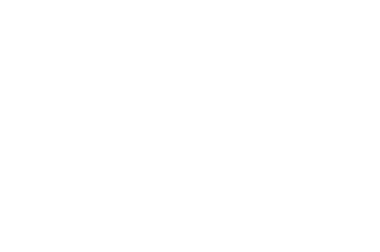

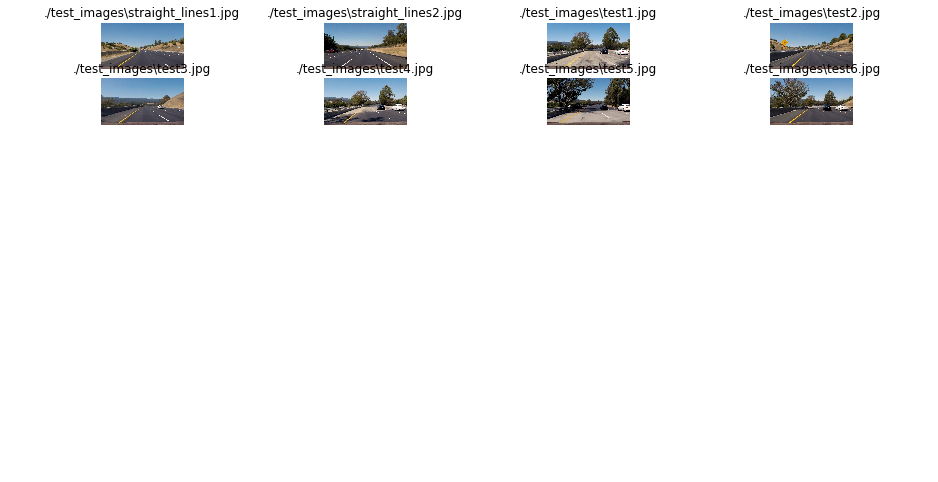

In [26]:
import glob
image_files = glob.glob('./test_images/*.jpg')
imgs_camera = []
for img_file in image_files:
    imgs_camera.append(cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB))
plot_images_grid(imgs_camera, labels=image_files)

## Undistort Images

In [5]:
from camera_img_undistorter import CameraImageUndistorter
img_undistorter = CameraImageUndistorter()

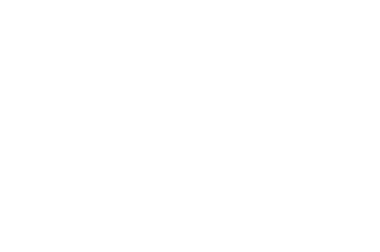

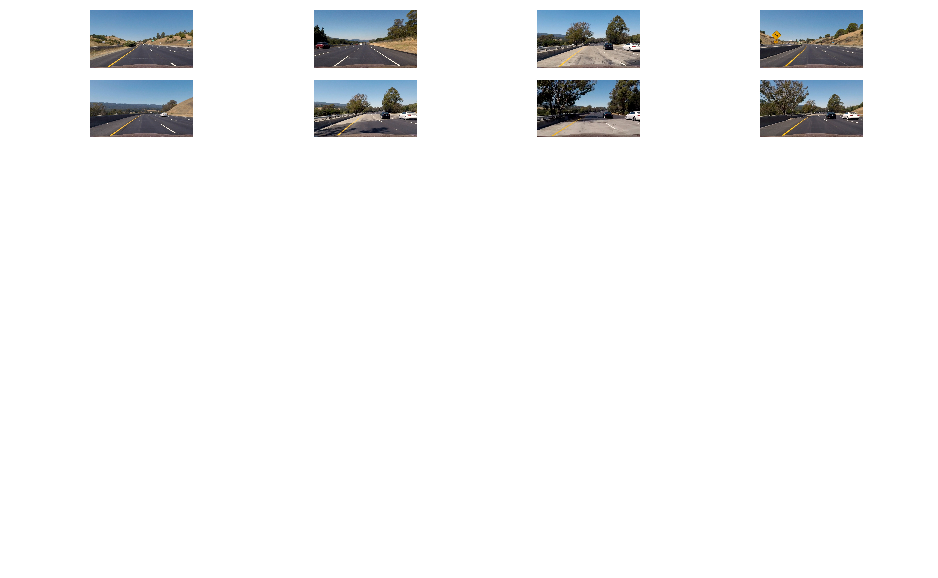

In [6]:
imgs_undistorted = [img_undistorter.undistort(img) for img in imgs_camera] 
plot_images_grid(imgs_undistorted)

## Determine Potential Lane Pixels

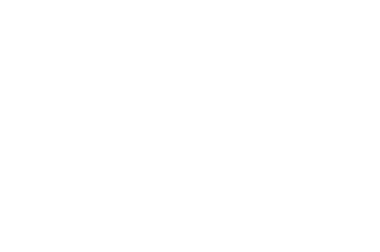

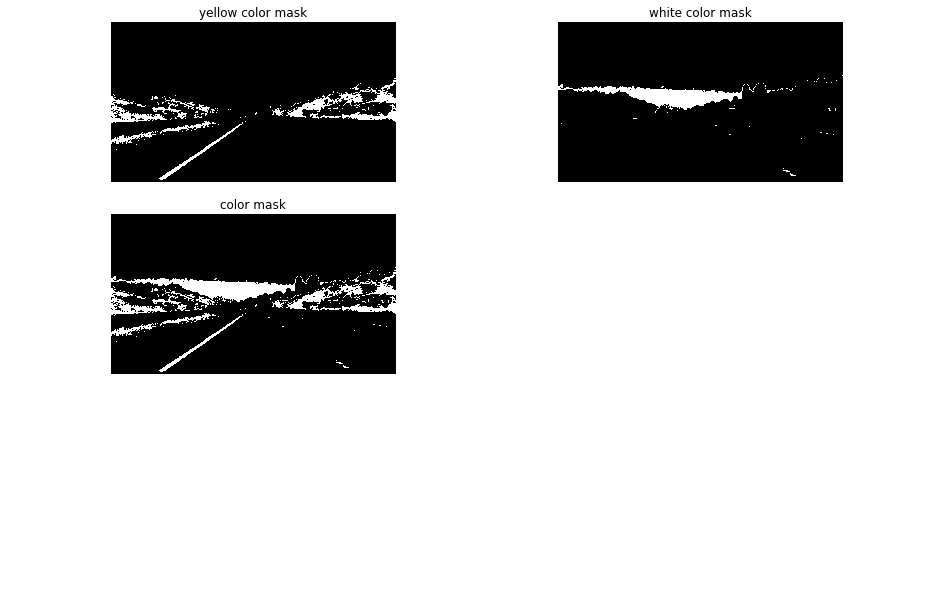

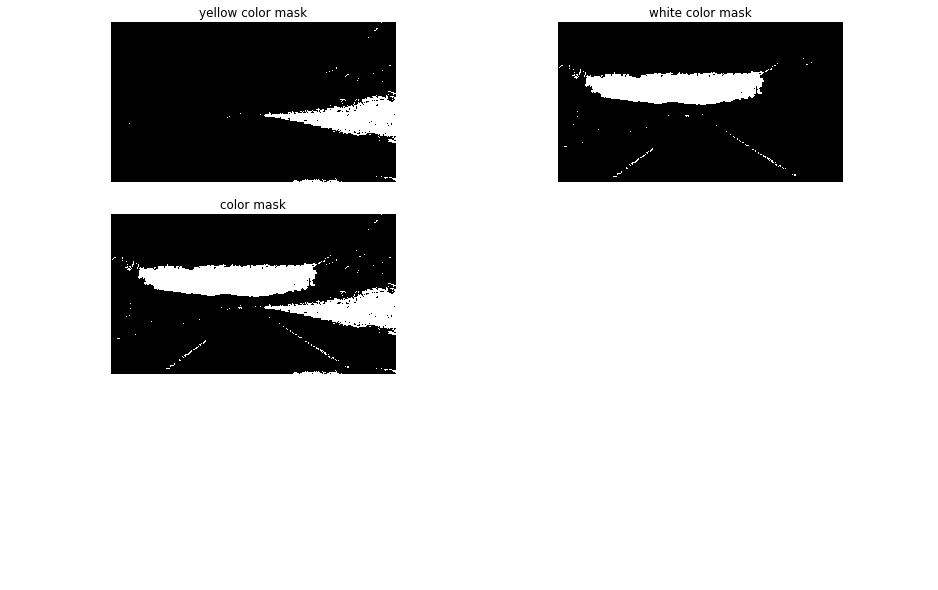

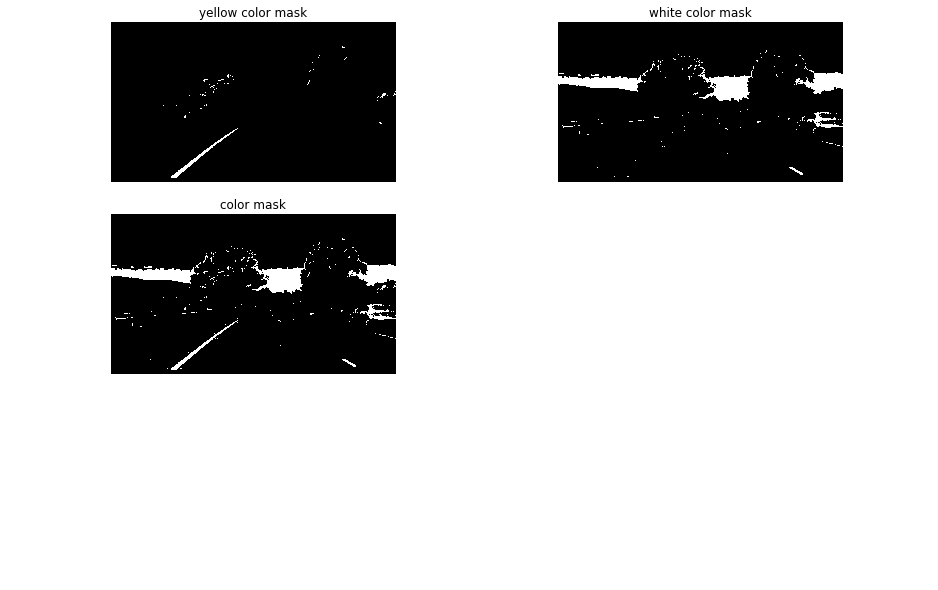

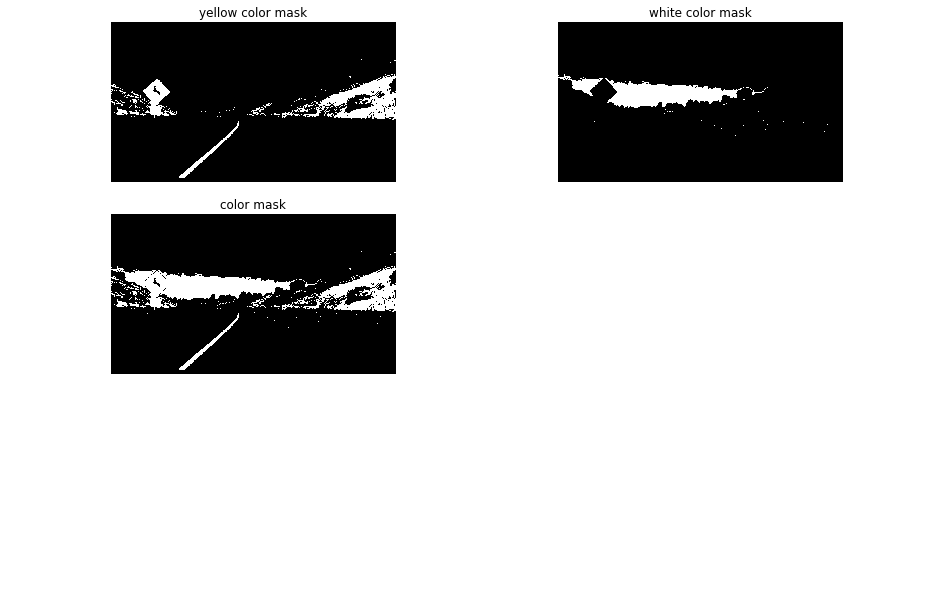

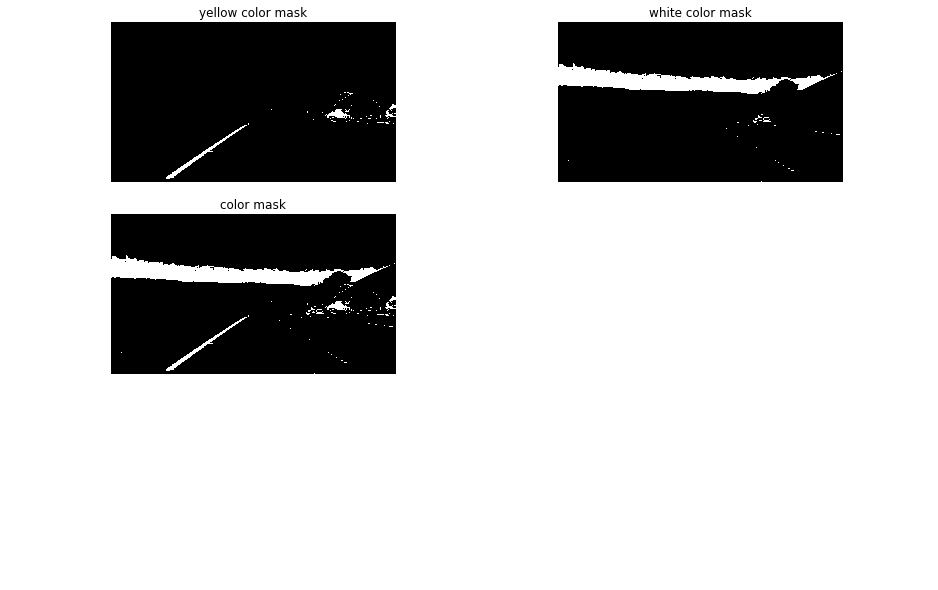

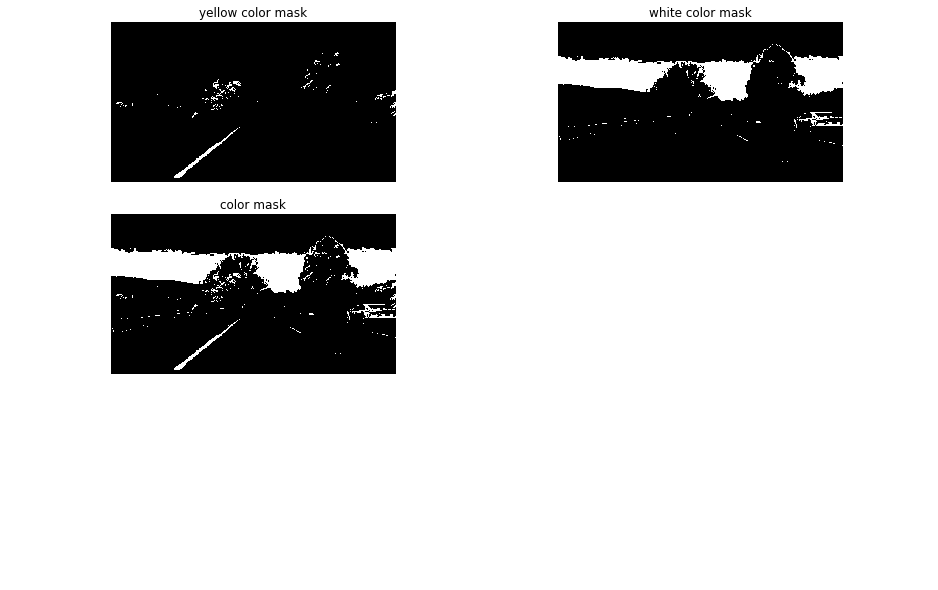

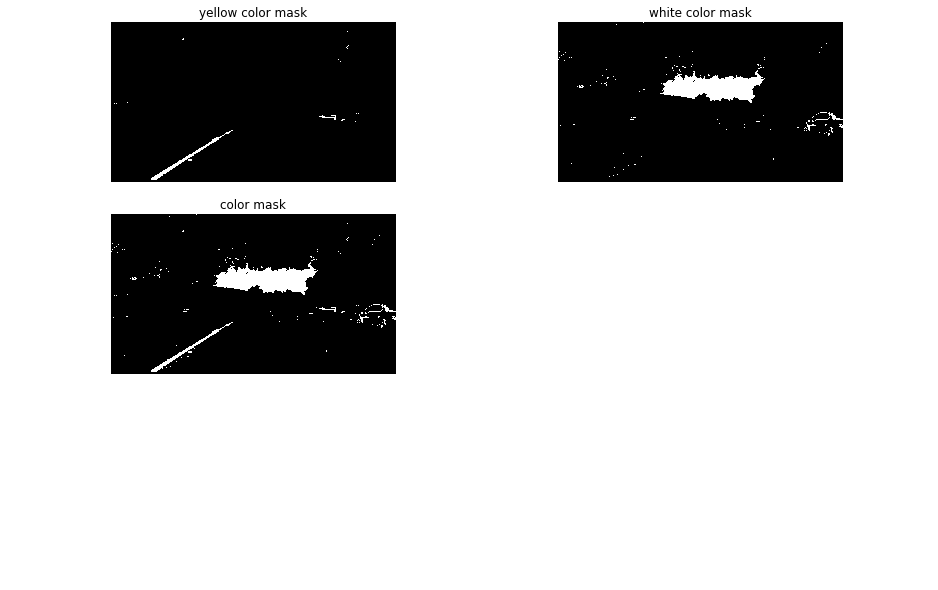

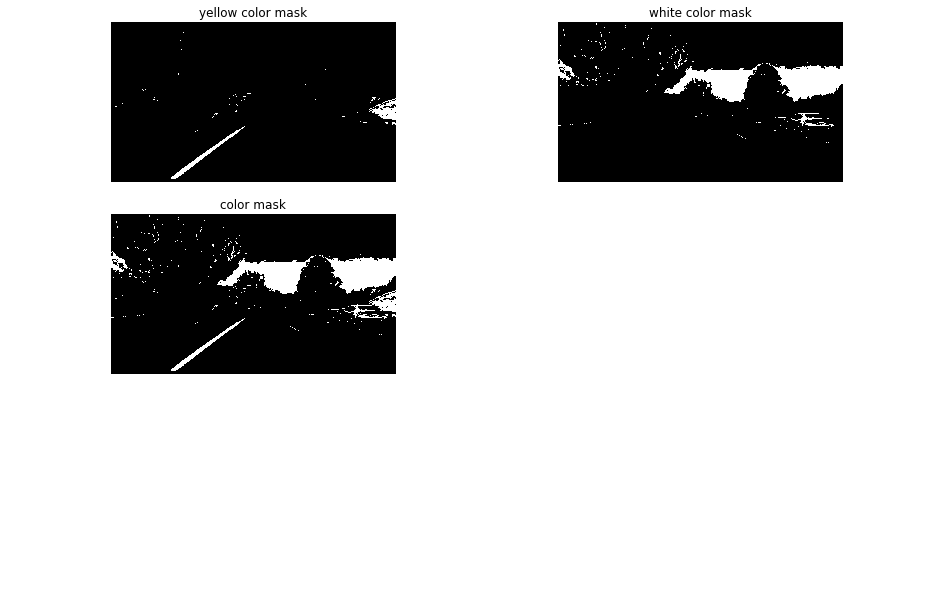

In [7]:
import lane_isolator
importlib.reload(lane_isolator)
from lane_isolator import LaneIsolator

trace_imgs = []
trace_img_labels = []
lane_isolator_trace_plot = True
    
def trace_image_lane_isolation(label, img):
    global trace_imgs
    global trace_img_labels
    if lane_isolator_trace_plot:
        trace_img_labels.append(label)
        trace_imgs.append(np.copy(img))

def create_lane_mask(img):
    global trace_imgs
    global trace_img_labels
    trace_imgs = []
    trace_img_labels = []
    mask = lane_isolator.isolate_lanes(img)
    plot_images_grid(trace_imgs, labels=trace_img_labels, cmap='gray')
    return mask
    
lane_isolator = LaneIsolator(
    ksize=15,
    gradx_thresh=(30, 255),
    grady_thresh=(10, 255),
    mag_thresh=(10, 255),
    dir_thresh = (-0.7, 0.7),
    trace_intermediate_image=trace_image_lane_isolation)
imgs_lanes  = [create_lane_mask(img) for img in imgs_undistorted] 

#plot_images_grid(imgs_lanes, cmap='gray')

lane_isolator_trace_plot = False

## Transforming to Birdview

In [8]:
import camera_birdview_transform
importlib.reload(camera_birdview_transform)
from camera_birdview_transform import CameraImagePerspectiveTransform
img_transformer = CameraImagePerspectiveTransform()

### Source Points for Perspective Transformation

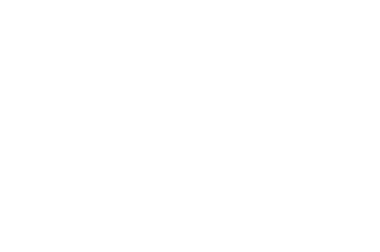

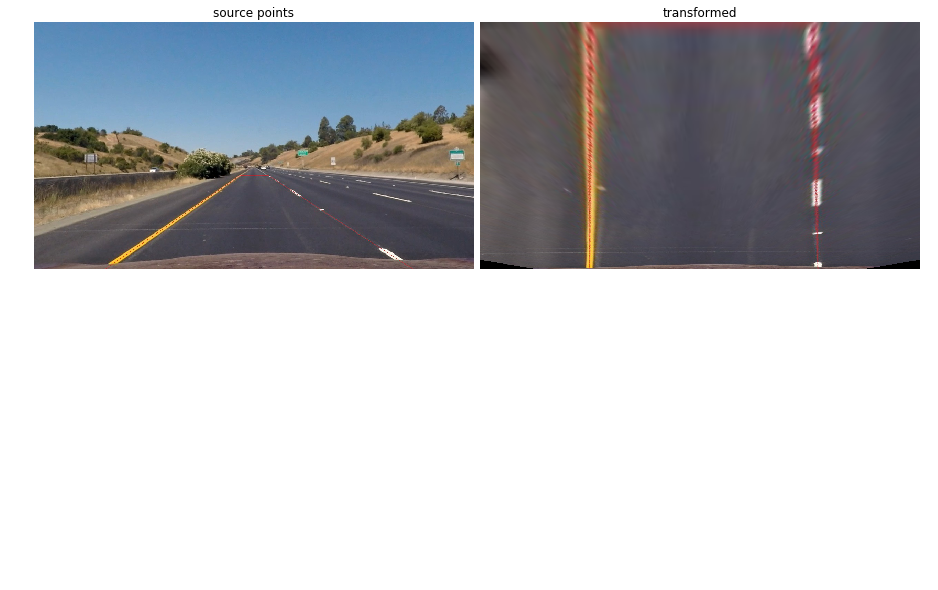

In [9]:
img_warp_ex_source = cv2.cvtColor(cv2.imread('./output_images/straight_lines1_source.jpg'), cv2.COLOR_BGR2RGB)
img_warp_ex_result = img_transformer.to_birdview(img_warp_ex_source)
plot_images_grid([img_warp_ex_source, img_warp_ex_result], labels=['source points', 'transformed'])


### Perspective Transform for All Test Images

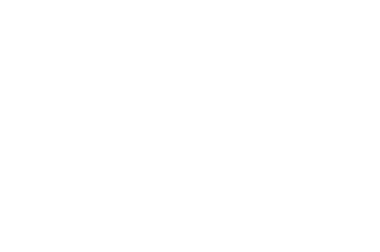

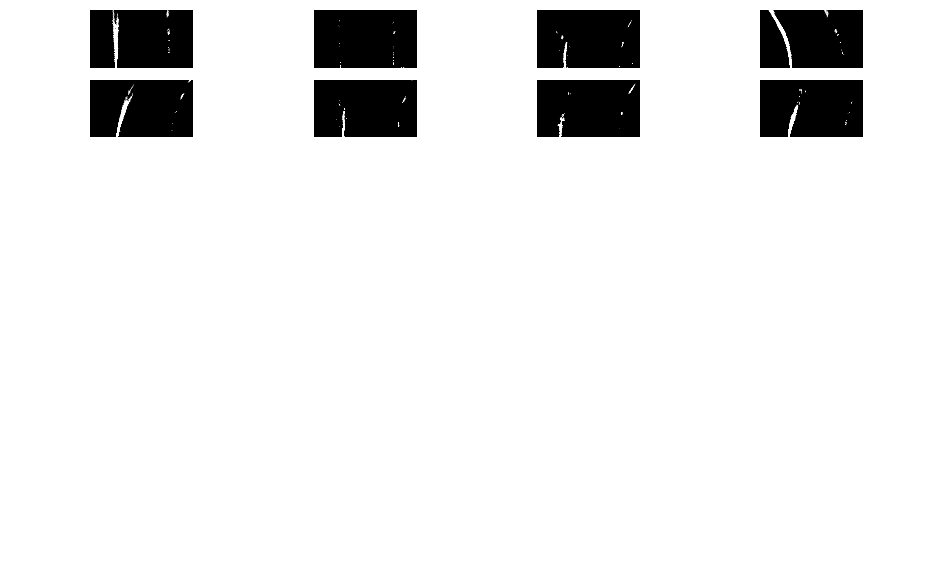

In [10]:
imgs_birdview = [img_transformer.to_birdview(img) for img in imgs_lanes]
plot_images_grid(imgs_birdview, cmap='gray')

## Histogram to Find Base of Lane Lines

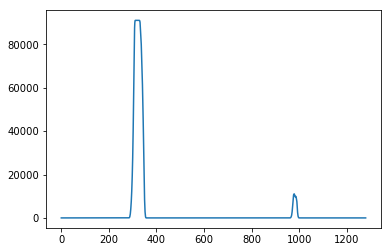

In [11]:
histograms = [np.sum(img[img.shape[0]//2:,:], axis=0) for img in imgs_birdview]
plt.plot(histograms[0])

## Fit Lanes for Test Images

deviation from lane center: 0.0618013826257
lane radius meters: 2748.45298197
lane width meters: 3.84566913325


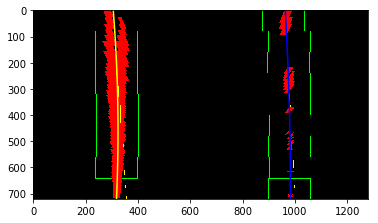

In [19]:
import lane
importlib.reload(lane)
from lane import FittedLane
        
lane_fit_trace_imgs = [np.zeros_like(img) for img in imgs_undistorted]
fitted_lanes = [FittedLane.fit(img, img_trace) for img, img_trace in zip(imgs_birdview,lane_fit_trace_imgs)]

def plot_lane_lines(lane, fit_img):
    # Generate x and y values for plotting
    img_height = fit_img.shape[0]
    ploty = np.linspace(0, img_height-1, img_height )
    left_fitx = lane.line_left.x_pixels(ploty)
    right_fitx = lane.line_right.x_pixels(ploty)

    print("deviation from lane center: " + str(lane.deviation_from_lane_center_meters()))
    print("lane radius meters: " + str(lane.lane_radius_meters()))
    print("lane width meters: " + str(lane.lane_width_meters()))
    plt.imshow(fit_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='blue')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
plot_lane_lines(fitted_lanes[0],lane_fit_trace_imgs[0])

deviation from lane center: 0.0662246966466
lane radius meters: 1832.68885976
lane width meters: 3.73993069618


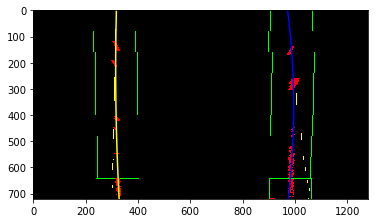

In [20]:
plot_lane_lines(fitted_lanes[1],lane_fit_trace_imgs[1])

## Draw Detected Lane on Test Images

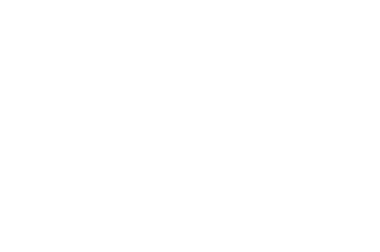

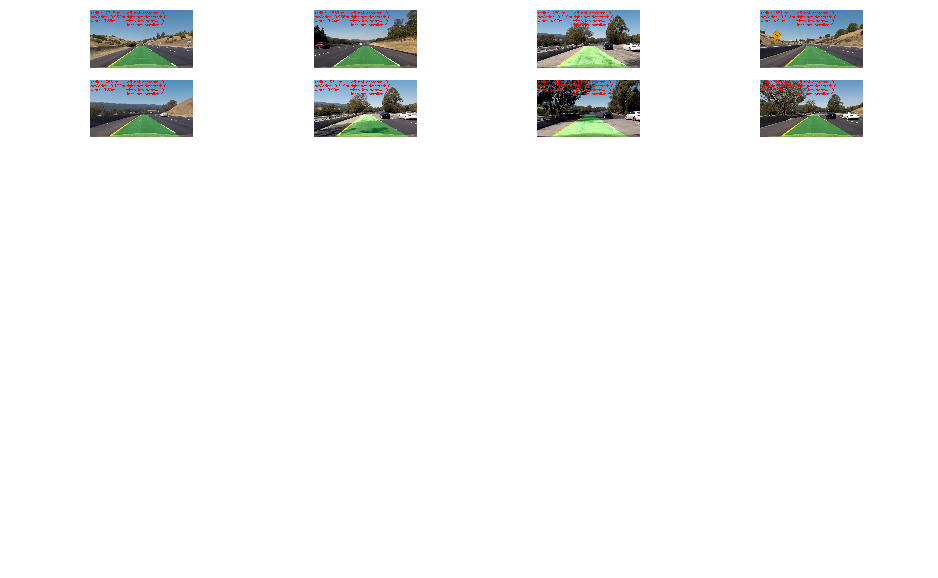

In [21]:
import lane_image_augmentation
importlib.reload(lane_image_augmentation)
from lane_image_augmentation import LaneImageAugmenter

lane_img_augmenter = LaneImageAugmenter(img_transformer)
imgs_augmented = [lane_img_augmenter.draw_all(undist, lane) for undist, lane in zip(imgs_undistorted, fitted_lanes)]
plot_images_grid(imgs_augmented)

## Pipeline for Video

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

importlib.reload(lane)
from lane import FittedLane

import lane_smoother
importlib.reload(lane_smoother)
from lane_smoother import LaneSmoother

importlib.reload(lane)
from lane import FittedLane

lane_smooth = LaneSmoother()
def process_image(img):
    img_undistorted = img_undistorter.undistort(img)
    img_binary = lane_isolator.isolate_lanes(img_undistorted)
    img_binary_birdview = img_transformer.to_birdview(img_binary)
    lane = lane_smooth.fit(img_binary_birdview)
    return lane_img_augmenter.draw_all(img_undistorted, lane)

clip = VideoFileClip("project_video.mp4")
clip_cut = clip.subclip(19, 24)
clip_augmented = clip_cut.fl_image(process_image)
clip_augmented.write_videofile("project_video_result_jupyter.mp4", audio=False, progress_bar=False)

HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format("project_video_result_jupyter.mp4"))

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



[MoviePy] >>>> Building video project_video_result_jupyter.mp4
[MoviePy] Writing video project_video_result_jupyter.mp4
[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result_jupyter.mp4 

